# TASKS: 

For each connecting rod appearing in the image, the vision system should provide the following information:  
 
1. Type of rod (type A = rod with 1 hole or type B = rod with 2 holes). 

2. Position and orientation (modulo pi). 

3. Length (L), Width (W), Width at the barycenter (WB).

4. For each hole, position of the center and diameter size.  
 

# LIBRARIES:

In [1]:
import numpy as np
import cv2 
from matplotlib import pyplot as plt
from math import degrees, radians
from sklearn.linear_model import LinearRegression

%matplotlib inline 

print("The OpenCV version is:", cv2.__version__)

The OpenCV version is: 3.4.2


# IMAGE IMPORTATION:

(255, 256)


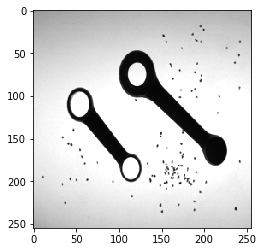

In [2]:
# images: 00 01 12 21 31 33 44 47 48 49 50 51 90 92 98
image = cv2.imread('TESI90.BMP',cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray', vmin=0, vmax=255);

print(image.shape)


# IMAGE FILTERING
The first thing to do is to deal with noise. We can deal with the scattered iron powder as if it is an impulsive noise, so with a median filter. But it would add another problem: the hole of some rods would be merged with the background. So I deal with the scattered iron powder in another way: When I compute the blobs I set a minimum number of pixels composing it.
The Gaussian filter is useful to reduce the dimension of the residual scattered iron powder (especially the one merged with the blobs).

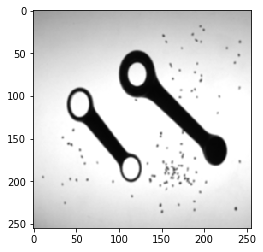

In [3]:
image = cv2.GaussianBlur(image, (3,3), 0)

#image = cv2.medianBlur(image, 5) 
plt.imshow(image, cmap='gray', vmin=0, vmax=255);

# BINARIZATION: ADAPTIVE THRESHOLDING
The adaptive thresholding methods are robust to light changes, that's why it's a good choice one of these methods in this case.


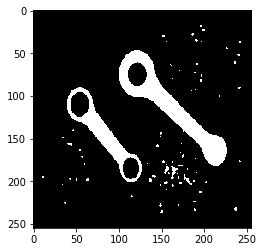

In [4]:
image_b = cv2.adaptiveThreshold(image,  maxValue = 255, adaptiveMethod = cv2.ADAPTIVE_THRESH_MEAN_C, thresholdType = cv2.THRESH_BINARY_INV, blockSize = 71, C =50)

# image_b is the output: the image binarized.
# maxValue is the value assigned to those pixels with intensity over the threshold.
# the threshold in each window is computed applying the mean filter.
# block_size is one dimension of the window/neighborhood.
# C is the quantity subtracted to move the threshold, in order to avoid introducing artefacts when filter applied to uniform regions.

plt.imshow(image_b, cmap ='gray', vmin = 0, vmax = 255);


# problem: i chose the value of C and the window doing try-error with these images. Is going to work with images with different lights?
# The advantage is that wrt to the other methods I have more control on the output thanks to the parameters C and WindowSize

# DEALING WITH SCATTERED IRON POWDER:
To remove the scattered iron powder I compute the blobs in the image and remove all the blobs with a number of pixels (=Area) lower than a certain threshold. This threshold value has been simply supposed by observing the given images.

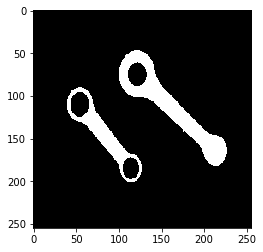

In [5]:
n_labels, img_labels = cv2.connectedComponents(image_b,connectivity=8)

threshold = 100

Dict_blobs = {}
Dict_sum = {}
Dict_area = {}

for i in range(0,img_labels.shape[0]):
    for j in range(0,img_labels.shape[1]):
        label = img_labels[i,j]
        if  label != 0:
            try:
                Dict_blobs[str(label)].append([i,j])
                Dict_sum[str(label)] += np.array([i,j])
                Dict_area[str(label)] += 1
            except KeyError:
                Dict_blobs[str(label)] = [[i,j]]  #double parenthesis otherwise the append does this: [i1,j1,[i2,j2],..] instead of  [[i1,j1],[i2,j2]...] 
                Dict_sum[str(label)] = np.array([i,j])
                Dict_area[str(label)] = 1

for label,pixel_list in Dict_blobs.items():
    if Dict_area[label] < threshold:
        for pixel in pixel_list:
            image_b[pixel[0],pixel[1]] = 0
                
plt.imshow(image_b, cmap= 'gray', vmin = 0, vmax = 255);
image_denoised = image_b

# DEALING WITH TOUCHING RODS:
# dilation of the regions close to the holes
After finding the zone of contact between rods and dividing them it could happen that because of the division the extremity of the rod could be corrupted, merging the hole with the background. In order to avoid this to happen, is necessary to increase the pixels which describe the ring around the hole of the rods. To do that is possible to apply erosion to the background with a kernel having a shape similar to the hole, so an ellipse:

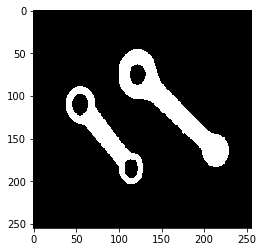

In [6]:
background_image = image_b.copy()
background_image[image_b == 0 ] = 255
background_image[image_b == 255] = 0

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
background_image = cv2.erode(background_image, kernel, iterations = 1)

image_b=background_image.copy()
image_b[background_image == 0] = 255
image_b[background_image == 255] = 0

plt.imshow(image_b, cmap='gray', vmin = 0, vmax = 255);



# DEALING WITH TOUCHING RODS:
# finding the critical points solution 1

The idea is to check all the contours with no parents, which are the rods. Those could be constituted by touching objects. Thanks to the knowledge of the shapes of the rods is possible to predict that if there is a zone of contact between rods, then necessarily at least one round extremity of a rod is involved. Thanks to this is possible to individuate the zone of contact in this way:
- compute the derivative of lines described by little group of points (at least two) along the contour.
- the derivative shouldn't change sign by comparing the lines described by the group of pixels belonging to a single rod contour. So if two near groups define derivatives with opposite sign, then probably that's a point of connection between two rods.

Luckily only two points per contact zone are individuated. I call these points 'CRITICAL POINTS'.
These are used to divide the rods.

More details:

If the points for each contact zone where more than two then could have been needed an additional condition, like NMS based on differences of derivatives. But this doesn't happen so it doesn't look necessary.

The division of the blob is done by using two segments: 
One starting from a critical point. Another segment starting from the other critical point. The segment meet at a point which is at about the middle of the two critical points, but shifted a little bit basing on some conditions. Two segments are used instead of one in order to define a division of the rods which tries to deal with  both possible touching elements of a rod:
the round extremity or the straight body.


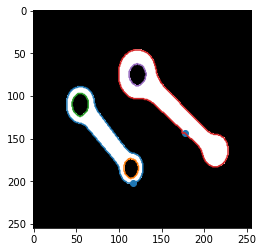

In [7]:
image_b, contours, hierarchy = cv2.findContours(image_b, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
plt.imshow(image_b, cmap ='gray', vmin = 0, vmax = 255);
critical_points = []

# I store to which contour each critical point belongs, to check fastly the condition that two corresponding critical points
# must belong to the same contour:
critical_points_contour = []

# the parameter 'par' determines the number of pixels belonging to the contour used to make a group
# which will describe the line of which the derivative is taken:
par = 3

# this determine how much two critical points must be distant (in terms of points along the contour):
min_dist_critical_points = 50 

for c in range(len(contours)): 
    plt.plot(contours[c][:,0][:,0],contours[c][:,0][:,1])
    #plt.text(contours[c][0][0][0],contours[c][0][0][1], c, bbox=dict(facecolor='blue', alpha=0.5))
    
    if hierarchy[0][c][3] == -1:  #I have to check only the outer contours, so the ones with no parents.
       
        i_coord_contour = contours[c][:,0][:,0]
        j_coord_contour = contours[c][:,0][:,1]
        
        i = par
        count = min_dist_critical_points + 1
        while i < len(i_coord_contour):
                x = i_coord_contour[i-par:i].reshape(-1,1) # needed for the fit function to reshape this array.
                y = j_coord_contour[i-par:i]
                model = LinearRegression().fit(x,y)
                m = model.coef_
            
                if i == par:
                    L_orientations = [m] * (par) # it associates to the first par contour pixels these orientations: [m,m,m...]
                
                L_orientations.append(m)
                  
                
                if ((L_orientations[-2]*L_orientations[-1]) <0) & (count> min_dist_critical_points):
                
                    critical_points.append([i_coord_contour[i], j_coord_contour[i]])
                    critical_points_contour.append(c)
                    count = 0
                    
                    
                i +=1
                count +=1
                
critical = True
if len(critical_points) >1:
    critical_points = np.array(critical_points)
    plt.scatter(critical_points[:,0],critical_points[:,1])

else: critical = False


# DEALING WITH TOUCHING RODS:
# finding the critical points solution 2

The idea is to check all the contours with no parents, which are the rods. Those could be constituted by touching objects. Thanks to the knowledge of the shapes of the rods is possible to predict that if there is a zone of contact between rods, then necessarily at least one round extremity of a rod is involved. Thanks to this is possible to individuate the zone of contact in this way:
- FIRST CONDITION: I treat the contour as a function of which I am looking for extremas, in this way: if a pixel is greater or smaller than N of it neighbours, then it is a critical point. 
Same thing for a pixel being the leftmost or rightmost pixel than N of its neighbours. 
- SECOND CONDITION: If it is a zone with many of these points satisfying the first condition, because there are many point with the same row or same column, for sure we're not talking about a touching zone because it has a round shape.

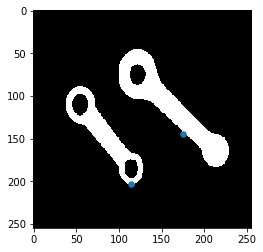

In [8]:
image_b, contours, hierarchy = cv2.findContours(image_b, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
plt.imshow(image_b, cmap ='gray', vmin = 0, vmax = 255);
critical_points = []

# I store to which contour each critical point belongs, to check fastly the condition that two corresponding critical points
# must belong to the same contour:
critical_points_contour = []

# the parameter 'par' determines the round(HALF)-1 of the number of pixels belonging to the contour used to make a group
# which will describe the neighbourhood of the considered pixel.
par = 3

# this determine how much two critical points must be distant (in terms of points along the contour):
min_dist_critical_points = 50 

for c in range(len(contours)): 
    #plt.plot(contours[c][:,0][:,0],contours[c][:,0][:,1])
    #plt.text(contours[c][0][0][0],contours[c][0][0][1], c, bbox=dict(facecolor='blue', alpha=0.5))
    
    if hierarchy[0][c][3] == -1:  #I have to check only the outer contours, so the ones with no parents.
       
        i_coord_contour = contours[c][:,0][:,0]
        j_coord_contour = contours[c][:,0][:,1]
        
        i = par  
        count = min_dist_critical_points + 1
        while i < len(i_coord_contour):
               # first condition:
            if (i_coord_contour[i] == max(i_coord_contour[i-par:i+par])) or \
            (i_coord_contour[i] == min(i_coord_contour[i-par:i+par])) or \
            (j_coord_contour[i] == max(j_coord_contour[i-par:i+par])) or \
            (j_coord_contour[i] == min(j_coord_contour[i-par:i+par])):
                        
                        # second condition:
                        if not(i_coord_contour[i] in i_coord_contour[i-par:i-1] or i_coord_contour[i] in i_coord_contour[i+1:i+par] or \
                           j_coord_contour[i] in j_coord_contour[i-par:i-1] or j_coord_contour[i] in j_coord_contour[i+1:i+par]) :
                                
                                critical_points.append([i_coord_contour[i], j_coord_contour[i]])
                                critical_points_contour.append(c)
     
            i +=1
        
# remove critical points which are too close:
critical_points_new = critical_points[:]
for i in range(len(critical_points)-1):
    if ( (critical_points[i][0]-critical_points[i+1][0])**2 + (critical_points[i][0]-critical_points[i+1][0])**2) **(1/2) <= 4:
        del critical_points_new[i+1]
        
critical_points=critical_points_new
        
    
                
critical = True

if len(critical_points) >1:
    critical_points = np.array(critical_points)
    plt.scatter(critical_points[:,0],critical_points[:,1],s=30)

else: critical = False
#print(critical_points)

# DEALING WITH TOUCHING RODS:
# finding correspondences between critical points

Is it possible that in one image there are more touching rods, or anyway many critical points. So is needed to find the critical points belonging to the same contact zone:
to do that i must find the pair of critical points which are reciprocally the Nearest Neighbour, and also belonging to the same contour.
I call L_correspondences a list containing pairs of corresponding critical points.

In [9]:
if critical:
    min_dist_points = []

    for i in range (len(critical_points)):
        min_dist = 10000
        for j in range(len(critical_points)):
            if j != i:
                dist = np.linalg.norm(critical_points[i]-critical_points[j],2) #euclidean distance 
                if (dist < min_dist):
                        min_dist = dist
                        min_d_point=j
        min_dist_points.append(critical_points[min_d_point])

      
    L_correspondences = []

    # conversion of the array critical points in a list containing lists in order to exploit the method 'index':
    critic_points = []
    for i in range(len(critical_points)):
        critic_points.append(list(critical_points[i]))
    critical_points = critic_points
    
    for i in range(len(critical_points)):    
        
       
            corr_point_index = critical_points.index(list(min_dist_points[i]))
        # I put some conditions to be correspondent points:
        # 1) the two critical points belong to the same contour
        # 2) the two critical points are reciprocally the nearest neighbours
            if (critical_points_contour[i] == critical_points_contour[corr_point_index]) & \
            (critical_points[i] == list(min_dist_points[corr_point_index])):  
                    L_correspondences.append( [critical_points[i], critical_points[corr_point_index]] )

            
        

    for el in L_correspondences:
        if [el[1],el[0]] in L_correspondences:
            L_correspondences.remove(el)


# DEALING WITH TOUCHING RODS:
# division of the touching rods.

I could simply track a segment for each pair of corresponding critical points. The problem is that in this way I risk to interrupt the 'ring' describing the perimeter of the holes. To avoid that I must use more segments. It seems to be enough to use two segments with these extremities:
1) one of the two critical point
2) a point in the middle wrt the pair of corresponding critical points, but shifted more or less orthogonally wrt the line connecting these two points.
In this way I avoid to interrupt the 'ring' but in some cases it can create a little distortion of the resulting rod.

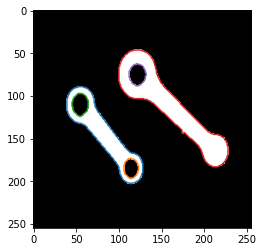

In [10]:
if critical:
    thickness=2 # thickness of the segments used to create the division of touching rods.
    shift = 5   # shift ot the point at which the two segments meet.
    color = (0,0,0)

    for el in L_correspondences:
        # m_d is true if the middle point(medium point between the corresponding critical points) shifted down belongs to a rod.
        m_d = False
        m_u = False
        m_diag1 = False
        m_diag2 = False
        m_diag3 = False
        m_diag4 = False
        
        start_point = tuple(el[0])
        end_point = tuple(el[1])
       
    
        #almost horizontal segment:
        if abs(el[0][0]-el[1][0]) < 3:  #almost the same i coordinate (row) between critical points
            
                        m_down = [int((el[0][0]+el[1][0])/2) + shift, int((el[0][1]+el[1][1])/2) ]
                        if image_b[m_down[0], m_down[1]]==255:
                                   m_d = True
                                   
                                
                        m_up = [int((el[0][0]+el[1][0])/2) - shift, int((el[0][1]+el[1][1])/2) ]
                        if image_b[m_up[0], m_up[1]]==255:
                                   m_u = True
                                   
                                    
                        if (m_d & m_u) == True:
                            middle_point = [int((el[0][0]+el[1][0])/2), int((el[0][1]+el[1][1])/2) ]
                            
                        elif m_d:
                            middle_point = m_right
                            
                        else:
                            middle_point = m_up
       
    
        #almost vertical segment:
        elif abs(el[0][1]-el[1][1]) < 3:   #almost the same j coordinate (column) between critical points
            
                        m_right = [int((el[0][0]+el[1][0])/2) , int((el[0][1]+el[1][1])/2) + shift ]
                        if image_b[m_right[0],m_right[1]]==255:
                                   middle_point= m_right
                            
                        else: #shift on the left otherwise:
                               middle_point = [int((el[0][0]+el[1][0])/2) , int((el[0][1]+el[1][1])/2)- shift]
       
    
        # almost diagonal segment:
        else:           
                        # diagonal1: in direction down-left
                        m_diagonal1 = [int((el[0][0]+el[1][0])/2) + shift, int((el[0][1]+el[1][1])/2) - shift]
                        if image_b[m_diagonal1[0],m_diagonal1[1]]==255:
                               m_diag1 = True
                        
                        # diagonal2: in direction up-right
                        m_diagonal2 = [int((el[0][0]+el[1][0])/2) - shift, int((el[0][1]+el[1][1])/2) + shift]
                        if image_b[m_diagonal2[0],m_diagonal2[1]]==255:
                               m_diag2 = True
                                
                        # diagonal3: in direction down-right
                        m_diagonal3 = [int((el[0][0]+el[1][0])/2) + shift, int((el[0][1]+el[1][1])/2) + shift]
                        if image_b[m_diagonal3[0],m_diagonal3[1]]==255:
                               m_diag3 = True
                                
                        # diagonal4: in direction up-left
                        m_diagonal4 = [int((el[0][0]+el[1][0])/2) - shift, int((el[0][1]+el[1][1])/2) - shift]
                        if image_b[m_diagonal4[0],m_diagonal4[1]]==255:
                               m_diag4 = True
                                
                        
                        if (m_diag1 & m_diag2 & m_diag3 & m_diag4) == True:
                            middle_point = [int((el[0][0]+el[1][0])/2), int((el[0][1]+el[1][1])/2) ]
                            
                        elif m_diag1 == False:
                            middle_point = m_diagonal2
                       
                        elif m_diag2 == False:
                            middle_point = m_diagonal1
                            
                        elif m_diag3 == False:
                            middle_point = m_diagonal4
                            
                        else:
                            middle_point = m_diagonal3
                                               
        middle_point= tuple(middle_point)                
    
        #segments:
        image_b = cv2.line(image_b, start_point, middle_point, color, thickness) 
        image_b = cv2.line(image_b, middle_point, end_point, color, thickness) 


        
    plt.imshow(image_b, cmap='gray', vmin=0, vmax=255);
    
    image_b, contours, hierarchy = cv2.findContours(image_b, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)


    for i in range(len(contours)):
        plt.plot(contours[i][:,0][:,0],contours[i][:,0][:,1])
        #plt.text(contours[i][0][0][0],contours[i][0][0][1],i,bbox=dict(facecolor='blue', alpha=0.5))       

# CLASSIFICATION OF THE OBJECTS IN THE IMAGE:
In order to individuate objects which are not rods I extract informations from the contours.
Thanks to the function findContours is possible to know easily if a contour has 'child' or 'parent' contours.
We know that the rods have at least one 'child contour' which defines the hole. So objects with no 'child contours' are not rods.
Then to discriminate the object which are not a rod but have a hole I use this condition:
the barycenter of the outer contour of a rod is never within a hole.
I call ROD_A the rods with only one hole, ROD_B the rods with two holes.

{1: 'HOLE', 2: 'HOLE', 4: 'HOLE', 0: 'ROD_B', 3: 'ROD_A'}


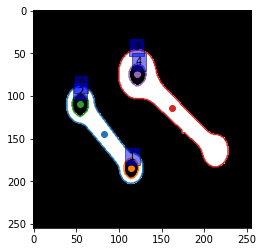

In [11]:
image_b, contours, hierarchy = cv2.findContours(image_b, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# info about the function fincContours: https://docs.opencv.org/master/d9/d8b/tutorial_py_contours_hierarchy.html.
# hierarchy: [Next, Previous, First_Child, Parent]

plt.imshow(image_b, cmap='gray', vmin=0, vmax=255);

Dict_info_contours = {}
Dict_number_holes = {}  # it stores the number of holes, only of the rods.
Dict_barycenter_contours = {}

for i in range(len(contours)):  # for each contour:
    
    i_coord_contour = contours[i][:,0][:,0]
    j_coord_contour = contours[i][:,0][:,1]
    
    barycenter = [int(sum(i_coord_contour)/len(i_coord_contour)),int(sum(j_coord_contour)/len(j_coord_contour))]
    
    plt.scatter(barycenter[0],barycenter[1])
    
    Dict_barycenter_contours[i] = barycenter 
    
    if hierarchy[0][i][2] == -1:  # this contour has no child -> it's a hole or an object different from a rod.
        
        if hierarchy[0][i][3] != -1: # it has no child but has a parent-> it's a hole
                Dict_info_contours[i] = 'HOLE'
                # I store the info that its parent has an hole:
                Dict_number_holes[hierarchy[0][i][3]] = Dict_number_holes.get(hierarchy[0][i][3],0) + 1 
          
        else:  # it has no child and no parent-> it's not a rod
                Dict_info_contours[i] = 'NO_ROD'
      
    
for key,value in Dict_number_holes.items():
    if value == 1:  # it could be the object with a hole which is not a rod.
        # compute barycenter of the contour to use it as condition to differentiate the rod from other objects:

        barycenter = Dict_barycenter_contours[key] 
        
        # because of the shapes of the object which is not a blob and has an hole:
        # if the barycenter of the contour is a pixel belonging to the foreground then it is a Rod.
        if image_b[barycenter[1], barycenter[0]] == 0 :
                Dict_info_contours[key] = 'NO_ROD'
 
        else: 
             Dict_info_contours[key] = 'ROD_A'
                
    if value == 2:
        Dict_info_contours[key] = 'ROD_B'
               
for i in range(len(contours)):
    plt.plot(contours[i][:,0][:,0],contours[i][:,0][:,1])
    plt.text(contours[i][0][0][0],contours[i][0][0][1],i,bbox=dict(facecolor='blue', alpha=0.5))       
        
print(Dict_info_contours)

# DESCRIPTION OF THE ROD'S HOLES:
In order to analyze only rod's holes a distinction must be done. This is easily done thanks to the information acquired before:
if the 'parent contour' of the hole is a rod, then it is a hole belonging to a rod.
The computation of the diameter of the holes is done by computing 4 radius (distances between the barycenter of the rod and the contour of the hole) in 4 directions: horizontally left and right, vertically up and down. So the diameter is the double of the mean of these 4 values. 

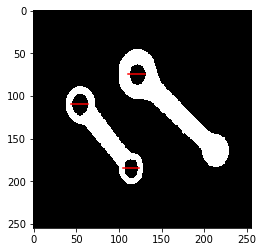

In [12]:
plt.imshow( image_b, cmap='gray', vmin=0, vmax=255);
Dict_hole_diameters = {}
Dict_hole_barycenters = {}
        
for key,value in Dict_info_contours.items():   
     
    if value == 'HOLE':
       
        if Dict_info_contours[ hierarchy[0][key][3] ] == 'NO_ROD':     # if the parent of the hole is a rod
            Dict_info_contours[key] = 'HOLE_NO_ROD'
        
        else: 
            Dict_info_contours[key] = 'HOLE_ROD'
            # only in this case the hole must be descripted, anyway the barycenter has been computed 
            # for all the holes for another porpuse.
            # But i still must compute the diameter.
            # I compute it as the double of the mean of 4 radious computed:
            
            barycenter = Dict_barycenter_contours[key] 
            
            upper_radious = 1
            while True:
                i,j=[barycenter[0] - (upper_radious + 1), barycenter[1]]
                if image_b[j,i] == 0:
                    upper_radious += 1
                else:
                    break

            lower_radious = 1
            while True:
                i,j= [barycenter[0] + (lower_radious + 1), barycenter[1]]
                if image_b[j,i] == 0:
                    lower_radious += 1
                else:
                    break
            
            right_radious = 1
            while True:
                i,j = [barycenter[0], barycenter[1] + (right_radious + 1)]
                if image_b[j,i] == 0:
                    right_radious += 1
                else:
                    break            
                    
            left_radious = 1
            while True:
                i,j = [barycenter[0], barycenter[1] - (left_radious + 1)]
                if image_b[j,i] == 0:
                    left_radious += 1
                else:
                    break                    
            
            radious = np.mean([upper_radious, lower_radious, right_radious, left_radious])
            Dict_hole_diameters[key] = 2*radious
            Dict_hole_barycenters[key] = barycenter
            plt.plot(np.linspace(barycenter[0]-int(radious), barycenter[0]+int(radious)), np.ones(50)*barycenter[1], 'r')
            
#print(Dict_info_contours)

# CONNECTED COMPONENT LABELLING
In order to do blob analysis I need to do Con. Comp. Lab.

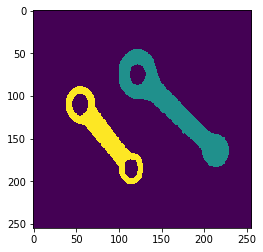

In [13]:
n_labels, img_labels = cv2.connectedComponents(image_b,connectivity=8)  
# connectivity=8 in order to label as belonging to the blob also pixels connected diagonally, to reduce the probability of
# interrupting the blob in the rings which define the holes.
# retval is the number of labels

plt.imshow(img_labels, vmin=0, vmax=n_labels-1);

# BLOB ANALYSIS: AREA
 While computing the area I compute something which is useful for the continue of blob analysis: for each blob an array of shape = (n°pixels of that blob , 2 )
 containing the indexes of the pixels belonging to it. 
 These arrays will be stored into the Dict_blobs.
 In order to compute the barycenter is used a dictionary with the sum of coordinates of pixels belonging to the same blob.





In [14]:
Dict_blobs = {}
Dict_sum = {}
Dict_area = {}

for i in range(0,img_labels.shape[0]):
    for j in range(0,img_labels.shape[1]):
        label = img_labels[i,j]
        if  label != 0:
            try:
                Dict_blobs[str(label)].append([i,j])
                Dict_sum[str(label)] += np.array([i,j])
                Dict_area[str(label)] += 1
            except KeyError:
                Dict_blobs[str(label)] = [[i,j]]  #double parenthesis otherwise the append does this: [i1,j1,[i2,j2],..] instead of  [[i1,j1],[i2,j2]...] 
                Dict_sum[str(label)] = np.array([i,j])
                Dict_area[str(label)] = 1

# BLOB ANALYSIS: BARYCENTER
The dictionary Dict_barycenters will contain the indexes of the barycenter of each rod.
I could think to compute the barycenter just using the outer contour but it would work only for the rod with two holes because symmetric.

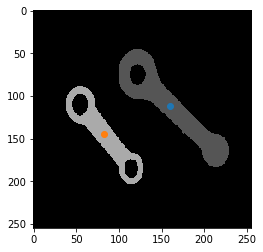

In [15]:
Dict_barycenters = {}
img_check = img_labels
plt.imshow(img_check, cmap='gray', vmin=0, vmax=3);

for key in Dict_sum:
    
    jb = int(Dict_sum[key][0]/Dict_area[key])
    ib = int(Dict_sum[key][1]/Dict_area[key])
    
    Dict_barycenters[key] = [ib, jb]
     
    plt.scatter(ib,jb)                 #uncomment to check the result

# DEALING WITH BARYCENTERS AND DIFFERENT LABELS:
I the barycenter of each road in two ways (because needed for different purposes): using the outer contour and using the blob pixels. To be precise the barycenter computed following the definition is given by the blob pixels. Since the label of the blobs and the labels of the outer contours are different because computed with different built in functions, I exploit the two computation of the barycenters to associate to each outer label the corresponding blob label. This association is stored in the Dict_label_translator. (This will be used in the alternative solution to compute the orientations of the blob).
During the computation of it I also create Dict_barycenter_new which associate to each label contour the barycenter computed with the blobs. (I'll exploit this dictionary to compute the width at the barycenter.)

In [16]:
Dict_barycenter_new = {}
Dict_label_translator = {}

for label_cont, bar_cont in Dict_barycenter_contours.items():
    
    if Dict_info_contours[label_cont] == 'ROD_A' or Dict_info_contours[label_cont] == 'ROD_B':
        min_dist = 10000
        
        for label_blob, bar_blob in Dict_barycenters.items():
            dist_bar = ( (bar_cont[0] - bar_blob[0])**2 + (bar_cont[1] - bar_blob[1])**2 ) ** (1/2)
            
            if dist_bar < min_dist:
                min_dist = dist_bar
                target_bar = bar_blob
                target_label = label_blob
                
        Dict_barycenter_new[label_cont] = target_bar
        Dict_label_translator[label_cont] = target_label
        
Dict_label_translator = {v: k for k, v in Dict_label_translator.items()}  
#Inversion of key-value because I'll exploit this dictionary to get contour labels from blob labels.

# WIDTH AT THE BARYCENTER:
Thanks to the symmetries of the rods I can compute the minimum distance between the barycenter and the pixel contours of the rod. 
The width is the double of this quantity.
ALTERNATIVE SOLUTION: FOUND THE PIXEL CONTOUR WITH MINIMUM DISTANCE (LET'S CALL IT MIN_P I REMOVE FROM THE CONTOUR THESE POINTS:
THE ONES ABOVE THE BARYCENTER IF MIN_P WAS ABOVE IT (OR VICE VERSA).
THE ONES ON THE LEFT WRT BARYCENTER IF MIN_P WAS ON THE LEFT SIDE OF IT (OR VICE VERSA).
AMONG THE REMAINING CONTOUR POINTS I FIND THE ONE WITH MINIMUM DISTANCE WRT THE BARYCENTER. lET'S CALL THIS POINT MIN_P2.
THE WIDTH AT THE BARYCENTER IS THE DISTANCE BETWEEN THESE 2 POINTS.

In [17]:
Dict_width_barycenter = {}

for label in range(len(contours)):
    
    if Dict_info_contours[label] == 'ROD_A' or Dict_info_contours[label] == 'ROD_B':
        i_coord_contour = contours[label][:,0][:,0]
        j_coord_contour = contours[label][:,0][:,1]
        bar = Dict_barycenter_new[label]
        
        min_dist = 10000
        for i in range(len(i_coord_contour)):
            dist_bar = ( (bar[0] - i_coord_contour[i])**2 + (bar[1] - j_coord_contour[i])**2 ) ** (1/2)
            if dist_bar < min_dist:
                min_dist = dist_bar
        Dict_width_barycenter[label] = min_dist*2
 

# ORIENTATION, LENGTH, WIDTH
I can use a function which computes all needed: minAreaRect.


In [18]:
Dict_orientation_rod = {}
Dict_length_rod = {}
Dict_width_rod = {}
#plt.imshow(image_b, cmap='gray', vmin=0, vmax=255);

for key,value in Dict_info_contours.items(): #I must do it only for rods:
    if value == 'ROD_A' or value == 'ROD_B':
        
        rect = cv2.minAreaRect(contours[key])
        orientation = rect[2]
        if rect[1][0] == max(rect[1][0],rect[1][1]):
            length = rect[1][0]
            width = rect[1][1]
            Dict_orientation_rod[key] = abs(orientation)
            
        else:
            length = rect[1][1]
            width = rect[1][0]
            Dict_orientation_rod[key] = -1*(90+orientation)
        
        #store informations:
        Dict_length_rod[key] = length
        Dict_width_rod[key] = width

# ALL THE RESULTS:
where ROD_A is the rod with one hole.

hole diameters:          {1: 18.5, 2: 21.0, 4: 21.0}
hole barycenters:        {1: [114, 184], 2: [54, 109], 4: [121, 74]}
width at the bar:        {0: 20.0, 3: 21.2602916254693}
orientation in degree:   {0: -53.130104064941406, 3: -48.14495849609375}
length:                  {0: 132.39999389648438, 3: 172.07247924804688}
width:                   {0: 37.60000228881836, 3: 51.26949691772461}
object classification:   {1: 'HOLE_ROD', 2: 'HOLE_ROD', 4: 'HOLE_ROD', 0: 'ROD_B', 3: 'ROD_A'}


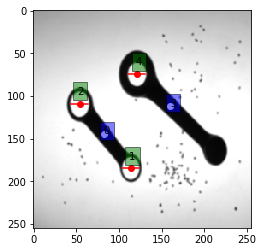

In [19]:
print('hole diameters:         ', Dict_hole_diameters)
print('hole barycenters:       ', Dict_hole_barycenters)
print('width at the bar:       ', Dict_width_barycenter)
print('orientation in degree:  ', Dict_orientation_rod)
print('length:                 ', Dict_length_rod)
print('width:                  ', Dict_width_rod) 
print('object classification:  ', Dict_info_contours)

plt.imshow(image, cmap='gray', vmin=0, vmax=255);
# see the result on image_denoised, image_b, image

for label,bar in Dict_barycenter_new.items(): 
    plt.text(bar[0], bar[1], label, bbox=dict(facecolor='blue', alpha=0.5)) 
    plt.scatter(Dict_barycenter_new[label][0],Dict_barycenter_new[label][1], color='white')
    

for i in range(len(contours)):
    if Dict_info_contours[i] == 'HOLE_ROD':
        #plt.plot(contours[i][:,0][:,0],contours[i][:,0][:,1])
        plt.text(contours[i][0][0][0],contours[i][0][0][1],i,bbox=dict(facecolor='green', alpha=0.5))
        plt.plot(np.linspace(Dict_hole_barycenters[i][0]-int(Dict_hole_diameters[i]/2), Dict_hole_barycenters[i][0]+int(Dict_hole_diameters[i]/2)), np.ones(50)*Dict_hole_barycenters[i][1], 'r')
        plt.scatter(Dict_hole_barycenters[i][0], Dict_hole_barycenters[i][1], color='red')
    
    if (Dict_info_contours[i] == 'NO_ROD') or (Dict_info_contours[i] == 'HOLE_NO_ROD') :
        plt.text(contours[i][0][0][0],contours[i][0][0][1],i,bbox=dict(facecolor='red', alpha=0.5))

# ALTERNATIVE SOLUTIONS WITHOUT USING THE FUNCTION MinAreaRect EXPLOITING SYMMETRIES:
(Only the first one has been implemented)

# 1)Without computing holes, using as unique information the pixels belonging to the rod:
To find the orientation is possible to exploit the symmetries of the blobs: Imagine the blob (of a rod) oriented having the major axis in vertical direction and divide the blob in three parts. For each part compute the barycenter. The major axis is the line with the minimum square error/distance wrt to these 3 points. This reasoaning can be generalized using more than 3 points. 
This should work dividing in horizontal or vertical parts because the rod is both vertical and horizontal symmetric.
But if the rod is not vertically oriented there's  little complication:
if the major axis is closer to the horizontal axis than the vertical axis, probably what is found is the minor axis applying this technique. So regardless what is the line obtained, must be computed also the line passing through the barycenter orthogonal to that line, and then determine which one is the minor and which the major axis. Or alternatively I prefered to change the array containing the pixels of the blob in order to split it vertically if the major axis is closer to the to the horizontal axis. (Indeed the pixels in the array 'blob' are sorted wrt the rows. I instead the condition is satisfied I order them wrt the column so splitting this array will be like splitting the blob in vertical sections instead than horizontals).

(Maybe this idea can work by using the outer contour of the rod instead than the whole blob, to save comp. cost).

ordered from the up-most blob:
 {'1': array([-47.42399696]), '2': array([-54.48077112])}


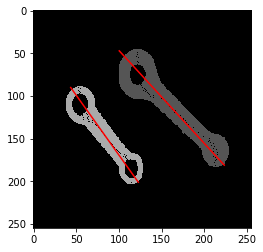

In [20]:
from sklearn.linear_model import LinearRegression

n_regions=100 # in how many regions to split the blob.

Dict_barycenters_regions = {}
Dict_orientations = {}

for label in Dict_blobs:
    try: # because if the object is not a rod it does an error when I try to use Dict_label_translator
        
        if (Dict_info_contours[Dict_label_translator[label]] == 'ROD_A') or (Dict_info_contours[Dict_label_translator[label]] == 'ROD_B'):
    
            blob = np.array(Dict_blobs[label])

            # check if the element has major axis closer to the horizontal or vertical axis:
            highest_row = blob[0,0]
            lowest_row = blob[-1,0]
            leftmost_column = min(blob[:,1])
            rightmost_column = max(blob[:,1])
            if (lowest_row - highest_row) < (rightmost_column-leftmost_column):
            # then the blob has major axis closer to the horizontal axis, so the code is the same but
            # i need to sort the blob pixels coordinates depending on the columns instead than the rows:
                blob = sorted(blob, key = lambda x: x[1])
        
        # split the blob in n_regions, and for each compute the barycenter. Then using linear regression find the line
        # which better fit to these barycenters
            regions = np.array_split(blob, n_regions, axis = 0)
            for i in range(0,n_regions):
                [ib,jb] = np.mean(regions[i],axis=0)
                ib = int(ib)
                jb= int(jb)
                img_check = img_labels 
                img_check[ib, jb] = 0  
                try:
                    Dict_barycenters_regions[label].append([ib,jb])
                except KeyError:
                    Dict_barycenters_regions[label] = [[ib,jb]]
       
    
            baricenters_region = np.array(Dict_barycenters_regions[label])
    
            x = baricenters_region[:,0].reshape(-1,1) #.reshape() on x because this array is required to be two-dimensional, or to be more precise, to have one column and as many rows as necessary.
            y = baricenters_region[:,1]
    
            model = LinearRegression().fit(x, y)
    
            q = model.intercept_
            m = model.coef_
            y_pred = m*x + q
    
            plt.imshow(img_check, cmap='gray', vmin=0, vmax=3);
            plt.plot(y_pred, x, color = "r") 
        #computation of the orientation exploiting m=tg(angle between the line and x axis):
            orientation =  np.degrees(np.arctan(m)) 
            if orientation >0:
                Dict_orientations[label] = orientation -90
            if orientation <0:
                Dict_orientations[label] = orientation +90
    except KeyError:
        continue

print("ordered from the up-most blob:\n",Dict_orientations)

# 2) Without computing holes, using as unique information the pixels belonging to the rod and the outer contour:
The orientation of the line can be obtained given two points: the barycenter of the rod and the pixel belonging to the outer contour with the maximum distance from it. (the double of this distance gives me also the length; the width is the double of the maximum distance between the pixels belonging to the outer contour and the major axis.)

# 3) The orientation is given by the line passing through the barycenters of the holes and the barycenter of the rod.